In [19]:
BiocManager::install("org.Hs.eg.db")  # Human organism database


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'org.Hs.eg.db'

installing the source package 'org.Hs.eg.db'


Old packages: 'GenomeInfoDb', 'KernSmooth', 'MASS', 'Matrix', 'MatrixGenerics',
  'R6', 'Rcpp', 'RcppArmadillo', 'SparseArray', 'bit64', 'bslib', 'class',
  'cli', 'cluster', 'curl', 'doBy', 'edgeR', 'enrichplot', 'evaluate',
  'foreign', 'httr2', 'igraph', 'limma', 'lintr', 'lme4', 'locfit', 'mvtnorm',
  'nlme', 'nnet', 'openssl', 'pkgbuild', 'processx', 'purrr', 'quantreg',
  'rlang', 'rpart', 'sessioninfo', 'spatial', 'survival', 'systemfonts',
  'testthat', 'textshaping', 'xfun', 'yulab.utils', 'zip'



In [21]:
# Load the libraries
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(ggplot2)
library(tidyverse)

# Define Thresholds

In [2]:
# Load the data - Table of significant genes
res_tbl <- read.csv("data/E_vs_C_all_genes.csv")
dim(res_tbl)
head(res_tbl)

[1] 14430     6

,gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MT-RNR2,904848.616,2.307590,0.02724077,0.000000e+00,0.000000e+00
2,MT-TP,3253.096,1.944385,0.05412532,1.003573e-284,5.411264e-281
3,MT-ND5,298801.231,1.111986,0.03115547,4.333748e-280,1.557838e-276
4,MTRNR2L2,2609.833,1.974944,0.05587488,2.128453e-275,5.738310e-272
5,MT-ATP6,118615.796,-1.112057,0.03392554,7.591171e-237,1.637264e-233
6,MT-ATP8,43908.463,-1.334777,0.04099192,5.001372e-234,8.989132e-231


In [3]:
# Gene names to row names
rownames(res_tbl) <- res_tbl$gene

# Re-order by padj
res_tbl_ordered <- res_tbl[order(res_tbl$padj), ]
head(res_tbl_ordered)

,gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-RNR2,MT-RNR2,904848.616,2.307590,0.02724077,0.000000e+00,0.000000e+00
MT-TP,MT-TP,3253.096,1.944385,0.05412532,1.003573e-284,5.411264e-281
MT-ND5,MT-ND5,298801.231,1.111986,0.03115547,4.333748e-280,1.557838e-276
MTRNR2L2,MTRNR2L2,2609.833,1.974944,0.05587488,2.128453e-275,5.738310e-272
MT-ATP6,MT-ATP6,118615.796,-1.112057,0.03392554,7.591171e-237,1.637264e-233
MT-ATP8,MT-ATP8,43908.463,-1.334777,0.04099192,5.001372e-234,8.989132e-231


In [4]:
# check genes have zero expression
res_tbl_ordered[which(res_tbl_ordered$baseMean == 0), ] |> data.frame()

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [5]:
# Define thresholds
padj_threshold <- 0.05
log2fc_threshold <- 2

# Filter the table
cond_1 <- res_tbl_ordered$padj < padj_threshold
cond_2 <- abs(res_tbl_ordered$log2FoldChange) > log2fc_threshold
deg_genes <- res_tbl_ordered[which(cond_1 & abs(cond_2)), ]
dim(deg_genes)
head(deg_genes)

[1] 33  6

,gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-RNR2,MT-RNR2,904848.6162,2.307590,0.02724077,0.000000e+00,0.000000e+00
PHLDA3,PHLDA3,2324.6078,2.068445,0.06995754,6.609096e-194,1.018179e-190
MT-RNR1,MT-RNR1,241605.1561,3.347647,0.11542506,2.774468e-186,3.739983e-183
ANXA1,ANXA1,701.1653,2.701233,0.11406008,3.068220e-126,3.007972e-123
CDKN1A,CDKN1A,560.0802,2.561907,0.11066463,8.385615e-120,7.535873e-117
GDF15,GDF15,416.1099,3.235153,0.13982884,2.376067e-119,1.971039e-116


In [6]:
# Extract gene identifiers (assuming row names are SGD IDs)
deg_gene_list <- rownames(deg_genes)
deg_gene_list |> length()
head(deg_gene_list, 20)

[1] 33

[1] "MT-RNR2"       "PHLDA3"        "MT-RNR1"       "ANXA1"        
 [5] "CDKN1A"        "GDF15"         "MT-TF"         "BTG2"         
 [9] "FOSL1"         "ANXA3"         "MT-TC"         "CXCL14"       
[13] "MTRNR2L8"      "MT-TA"         "CTB-36O1.7"    "MT-TM"        
[17] "PVRL4"         "MTRNR2L1"      "MTRNR2L10"     "RP11-115D19.1"

# Prepare Up and Down Regulated Gene List

In [7]:
# Upregulated genes
cond_up_1 <- res_tbl_ordered$padj < padj_threshold
cond_up_2 <- res_tbl_ordered$log2FoldChange > log2fc_threshold
up_genes <- res_tbl_ordered[which(cond_up_1 & cond_up_2), ]
up_gene_list <- rownames(up_genes)
head(up_gene_list, 10)

# Downregulated genes
cond_down_1 <- res_tbl_ordered$padj < padj_threshold
cond_down_2 <- res_tbl_ordered$log2FoldChange < -log2fc_threshold
down_genes <- res_tbl_ordered[which(cond_down_1 & cond_down_2), ]
down_gene_list <- rownames(down_genes)
head(down_gene_list, 10)

[1] "MT-RNR2" "PHLDA3"  "MT-RNR1" "ANXA1"   "CDKN1A"  "GDF15"   "MT-TF"  
 [8] "BTG2"    "FOSL1"   "ANXA3"

[1] "CTB-36O1.7" "IFT46"      "IRAK1"

In [8]:
up_gene_list |> length()
down_gene_list |> length()

[1] 30

[1] 3

# Perform the Over-Represented Analysis

## Enrichment of Up Regulated Genes

#### **1. What is GO enrichment analysis?**
GO enrichment analysis identifies overrepresented GO terms (e.g., biological processes, molecular functions, or cellular components) in a given list of genes compared to a background (all genes). It helps determine the biological roles of the genes of interest.

#### **2. Key Function: `enrichGO()`**
The `enrichGO()` function comes from the `clusterProfiler` R package and is used for GO enrichment analysis.

#### **3. Parameters Explained**
- **`gene`**: 
  - The list of genes of interest for enrichment analysis.
  - In this case, `up_gene_list` contains genes that are upregulated in the analysis (e.g., differentially expressed genes).
  - These are provided in the SGD (Saccharomyces Genome Database) **ORF IDs** (e.g., `YMR174C`).

- **`OrgDb`**: 
  - The annotation database for the organism. 
  - Here, `org.Sc.sgd.db` is the **OrgDb object** for *Saccharomyces cerevisiae* (baker's yeast).
  - This database contains mappings of gene IDs to GO terms, annotations, and other metadata.

- **`keyType`**:
  - Specifies the type of gene identifiers being used.
  - `"ORF"` indicates Open Reading Frame identifiers, such as `YMR174C`.

- **`ont`**:
  - The GO ontology to analyze:
    - `"BP"`: Biological Process.
    - Other options: `"MF"` (Molecular Function), `"CC"` (Cellular Component).
  - Here, it's analyzing biological processes.

- **`pAdjustMethod`**:
  - The method used for correcting **p-values** for multiple hypothesis testing.
  - `"BH"` refers to the **Benjamini-Hochberg** procedure, a widely used method to control the false discovery rate (FDR).

- **`pvalueCutoff`**:
  - Only GO terms with p-values below this threshold are considered significant.
  - Here, the cutoff is `0.05` (5%).

- **`qvalueCutoff`**:
  - A cutoff for the **q-value**, which is an adjusted version of the p-value.
  - GO terms with q-values below `0.2` (20%) are considered.

In [22]:
# Perform GO enrichment analysis for Biological Processes
ego_bp_up <- enrichGO(
    gene          = up_gene_list,
    OrgDb         = org.Hs.eg.db,       # Human organism database
    keyType       = "SYMBOL",           # Input is gene symbols
    ont           = "BP",               # Biological Process
    pAdjustMethod = "BH",              # Benjamin-Hochberg adjustment
    pvalueCutoff  = 0.05,
    qvalueCutoff  = 0.2
)


In [23]:
dim(ego_bp_up)
head(ego_bp_up)  # View the top results

[1] 33 12

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:1900118,GO:1900118,negative regulation of execution phase of apoptosis,3/16,23/18986,0.13043478,154.77717,21.43058,8.607229e-07,0.0005198766,0.0003297928,MTRNR2L8/MTRNR2L1/MTRNR2L10,3
GO:1900117,GO:1900117,regulation of execution phase of apoptosis,3/16,37/18986,0.08108108,96.21284,16.83584,3.749225e-06,0.0008139350,0.0005163338,MTRNR2L8/MTRNR2L1/MTRNR2L10,3
GO:0051384,GO:0051384,response to glucocorticoid,4/16,134/18986,0.02985075,35.42164,11.61280,4.042724e-06,0.0008139350,0.0005163338,ANXA1/CDKN1A/FOSL1/ANXA3,4
GO:0031960,GO:0031960,response to corticosteroid,4/16,156/18986,0.02564103,30.42628,10.71776,7.390812e-06,0.0011160126,0.0007079620,ANXA1/CDKN1A/FOSL1/ANXA3,4
GO:0097194,GO:0097194,execution phase of apoptosis,3/16,96/18986,0.03125000,37.08203,10.29301,6.688390e-05,0.0069930416,0.0044361574,MTRNR2L8/MTRNR2L1/MTRNR2L10,3
GO:0051412,GO:0051412,response to corticosterone,2/16,15/18986,0.13333333,158.21667,17.69012,6.946730e-05,0.0069930416,0.0044361574,CDKN1A/FOSL1,2


- ID: Gene Ontology term identifier (GO:XXXXXXX)

- Description: Brief description of the biological process

- GeneRatio: Ratio of genes in your input list belonging to that GO term (e.g., 34/238 means 34 genes out of 238 total input genes)

- BgRatio: Background ratio of genes for that GO term in the entire genome (e.g., 277/6476 means 277 genes out of 6476 total genome)

- RichFactor: Ratio between the gene proportion in your list vs. background (GeneRatio/BgRatio)

- FoldEnrichment: How many times more frequent the term is in your list compared to expected by chance

- zScore: Statistical measure of enrichment strength

- pvalue: Raw statistical significance

- p.adjust: P-value adjusted for multiple testing using BH method

- qvalue: False discovery rate analog of p-value, used for significance threshold

- Your code shows enrichment analysis for upregulated genes (up_gene_list) in yeast (S. cerevisiae), focusing on biological processes with adjusted p-value < 0.05 and q-value < 0.2.

In [24]:
# Sorting by Count
ego_bp_up_sorted <- ego_bp_up |> arrange(desc(Count))
head(ego_bp_up_sorted)

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051384,GO:0051384,response to glucocorticoid,4/16,134/18986,0.02985075,35.42164,11.612799,4.042724e-06,0.0008139350,0.0005163338,ANXA1/CDKN1A/FOSL1/ANXA3,4
GO:0031960,GO:0031960,response to corticosteroid,4/16,156/18986,0.02564103,30.42628,10.717763,7.390812e-06,0.0011160126,0.0007079620,ANXA1/CDKN1A/FOSL1/ANXA3,4
GO:0048545,GO:0048545,response to steroid hormone,4/16,340/18986,0.01176471,13.96029,7.003145,1.550973e-04,0.0133826785,0.0084895346,ANXA1/CDKN1A/FOSL1/ANXA3,4
GO:0050867,GO:0050867,positive regulation of cell activation,4/16,391/18986,0.01023018,12.13939,6.463730,2.649154e-04,0.0160008892,0.0101504421,ANXA1/CDKN1A/EBI3/ACTA2,4
GO:1900118,GO:1900118,negative regulation of execution phase of apoptosis,3/16,23/18986,0.13043478,154.77717,21.430579,8.607229e-07,0.0005198766,0.0003297928,MTRNR2L8/MTRNR2L1/MTRNR2L10,3
GO:1900117,GO:1900117,regulation of execution phase of apoptosis,3/16,37/18986,0.08108108,96.21284,16.835842,3.749225e-06,0.0008139350,0.0005163338,MTRNR2L8/MTRNR2L1/MTRNR2L10,3


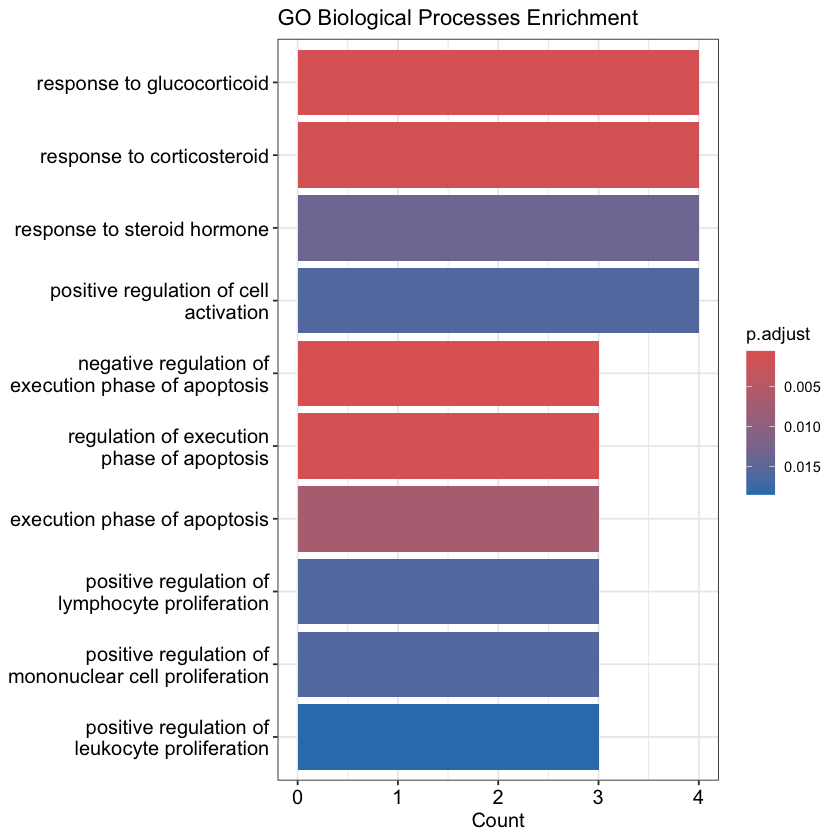

In [25]:
# Bar plot of top 10 enriched GO terms
barplot(
    ego_bp_up_sorted,
    showCategory = 10,
    orderBy = "Count",
    title = "GO Biological Processes Enrichment"
)

## Enrichment of Down Regulated Genes

In [33]:
# Perform GO enrichment analysis for Biological Processes
ego_bp_down <- enrichGO(
    gene          = down_gene_list,      # Your DEG list in SGD ORF IDs
    OrgDb         = org.Hs.eg.db,       # Human organism database
    keyType       = "SYMBOL",           # Input is gene symbols
    ont           = "BP",               # Biological Process
    pAdjustMethod = "BH",              # Benjamin-Hochberg adjustment
    pvalueCutoff  = 0.05,
    qvalueCutoff  = 0.2
)
dim(ego_bp_down)
head(ego_bp_down)

[1] 77 12

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008063,GO:0008063,Toll signaling pathway,1/2,13/18986,0.07692308,730.2308,26.99573,0.001368997,0.03362826,0.0004424771,IRAK1,1
GO:0034134,GO:0034134,toll-like receptor 2 signaling pathway,1/2,17/18986,0.05882353,558.4118,23.59961,0.001790039,0.03362826,0.0004424771,IRAK1,1
GO:0035720,GO:0035720,intraciliary anterograde transport,1/2,19/18986,0.05263158,499.6316,22.31946,0.002000526,0.03362826,0.0004424771,IFT46,1
GO:0002755,GO:0002755,MyD88-dependent toll-like receptor signaling pathway,1/2,20/18986,0.05000000,474.6500,21.75260,0.002105761,0.03362826,0.0004424771,IRAK1,1
GO:0034162,GO:0034162,toll-like receptor 9 signaling pathway,1/2,20/18986,0.05000000,474.6500,21.75260,0.002105761,0.03362826,0.0004424771,IRAK1,1
GO:1904996,GO:1904996,positive regulation of leukocyte adhesion to vascular endothelial cell,1/2,26/18986,0.03846154,365.1154,19.06922,0.002737057,0.03362826,0.0004424771,IRAK1,1


[1] 77 12

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008063,GO:0008063,Toll signaling pathway,1/2,13/18986,0.07692308,730.2308,26.99573,0.001368997,0.03362826,0.0004424771,IRAK1,1
GO:0034134,GO:0034134,toll-like receptor 2 signaling pathway,1/2,17/18986,0.05882353,558.4118,23.59961,0.001790039,0.03362826,0.0004424771,IRAK1,1
GO:0035720,GO:0035720,intraciliary anterograde transport,1/2,19/18986,0.05263158,499.6316,22.31946,0.002000526,0.03362826,0.0004424771,IFT46,1
GO:0002755,GO:0002755,MyD88-dependent toll-like receptor signaling pathway,1/2,20/18986,0.05000000,474.6500,21.75260,0.002105761,0.03362826,0.0004424771,IRAK1,1
GO:0034162,GO:0034162,toll-like receptor 9 signaling pathway,1/2,20/18986,0.05000000,474.6500,21.75260,0.002105761,0.03362826,0.0004424771,IRAK1,1
GO:1904996,GO:1904996,positive regulation of leukocyte adhesion to vascular endothelial cell,1/2,26/18986,0.03846154,365.1154,19.06922,0.002737057,0.03362826,0.0004424771,IRAK1,1


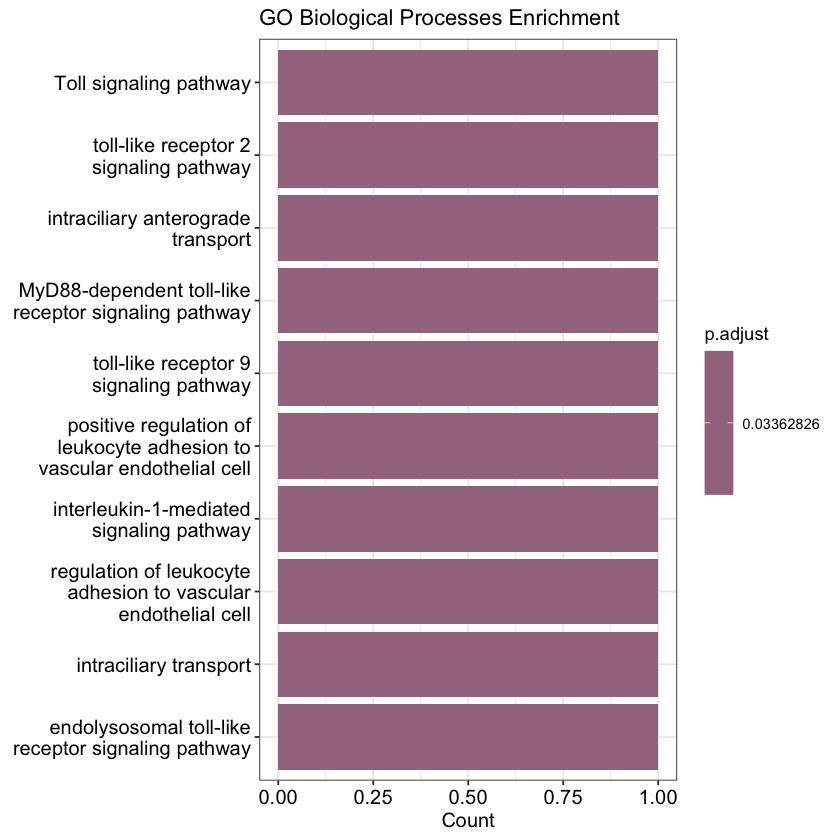

In [34]:
# sorting by Count
ego_bp_down_sorted <- ego_bp_down |> arrange(desc(Count))
dim(ego_bp_down_sorted)
head(ego_bp_down_sorted)

# Bar plot of top 10 enriched GO terms
barplot(
    ego_bp_down_sorted,
    showCategory = 10,
    orderBy = "Count",
    title = "GO Biological Processes Enrichment"
)